#Trialing Homemade Single Particle Diagnostics in Synergia

One of the diagnostics that will be needed for general diagnostics of nonlinearity and integrability is a diagnostic of the single particle invariant (which for a linear system is the Courant Synder invariant, which is essentially equivalent to $H = \sum_{i} {p_i}^2 + {q_i}^2$).

Note: This sort of calculation was done during Phase I with pyorbit outputs assuming an elliptical potential. See Stephen's [pyorbit script](https://github.com/radiasoft/iota/blob/master/Invariants.py) `invariant.py`.

Next I will ammend my poincare plot diagnostic to calculate particle trajectories in normal coordinates rather than trace space.

The next thing to calculate will be the beam envelope, which can be compared with Reiser's formula, and is what David did in [this github script](https://github.com/radiasoft/ioptics/blob/master/pyorbit/drift/driftEnvCalcs.py) `driftEnvCalcs.py`.


**General Guidelines (These hold for all examples within unless otherwise specified)**
1. The lattice simulator is constructed element-wise, using `Independent_stepper_elements`.
2. Bunch matching to a Gaussian distribution is performed in the transverse plane via `generate_matched_bunch_transverse`.
3. The simulations are performed without space charge effects.
4. 100 macro particles are used for the simulations.

**Major Required Dependencies**
1. Synergia
2. Numpy
3. Matplotlib

##Imports + Lattice Load

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 06/07/2015 

CPython 2.7.10
IPython 3.1.0


In [2]:
import sys
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# %load fodo.lat
focus := 7                   ! [m]     : focal length of equivalent
                             !         :   thin quad
sepn := 10                   ! [m]     : distance between quad centers
length := 2.0                ! [m]     : quadrupole length
strength := 1/(focus*length) ! [m**-2] : quadrupole strength
                             !         :   = B'/brho

beam, particle=proton, energy=1.5

o: drift, l=( sepn - length )
f: quadrupole, l=length, k1=strength
d: quadrupole, l=length, k1=(-strength)

fodo:  line=( f, o, d, o )


In [3]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("fodo","fodo.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #note this isn't using future division, so returns int

In [4]:
# %load fodo_options.py
#!/usr/bin/env python

import synergia_workflow

opts = synergia_workflow.Options("fodo")
opts.add("map_order", 3, "map order")
opts.add("steps_per_element", nsteps_per_element, "steps per element")
opts.add("emitx", 1.0e-6, "x RMS emittance [m-rad]")
opts.add("emity", 1.0e-6, "y RMS emittance [m-rad]")
opts.add("stdz", 0.01, "z RMS length [m]")
opts.add("dpop", 1.0e-4, "(delta p)/p")
opts.add("real_particles", 1.2e12, "number of physical particles in bunch")
opts.add("macro_particles", 100, "number of simulation particles")
opts.add("tracked_particles", opts.macro_particles, "number of tracked particles")
opts.add("seed", 1415926, "random number seed; 0 for automatic calculation (GSL)")
opts.add("turns", 1000, "number of times to track through fodo lattice")
opts.add("max_turns", 200, "maximum number of turns to run before checkpointing and stopping; 0 to not stop")
opts.add("checkpointperiod", 2000, "Number of turns to run between checkpoints", int)
opts.add("verbosity", 1, "verbosity level of simulation")

# Create the job manager for the simulation fodo.py, including the above options.
# When creating job directories, include the file fodo.lat.
#job_mgr = synergia_workflow.Job_manager("fodo.py", opts, ["fodo.lat"])



In [5]:
#construct stepper and get map
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()
lmap = lattice_simulator.get_linear_one_turn_map()

In [6]:
#Construct a bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

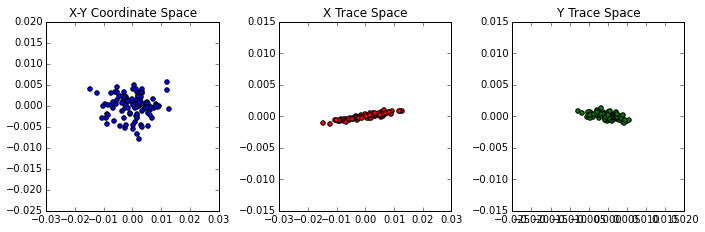

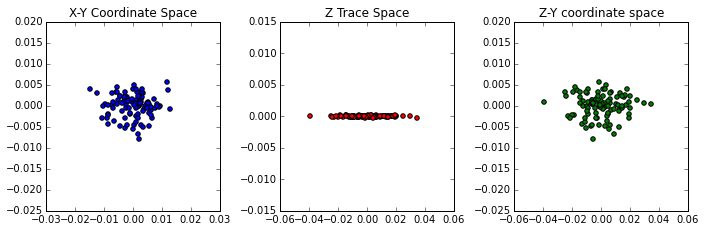

In [9]:
#Plot the bunch using my tools
from base_diagnostics import pltbunch

pltbunch.plot_bunch(myBunch)
pltbunch.plot_long(myBunch)

###Add diagnostics

In [10]:
# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5")
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5")
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("track.h5", 1))

#Diagnostics per turn - useful for invariant tracking
#bulktrackdiag = synergia.bunch.Diagnostics_bulk_track("turn_track.h5", opts.tracked_particles, 0)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_bulk_track("turn_track.h5", 2))

#bunch_simulator.add_per_turn(bulktrackdiag)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5")
bunch_simulator.add_per_turn(particlediag)

###Run the simulation

In [11]:
#~0.2s per turn for run with 100 macroparticles, ds = 0.01, 3rd order map
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.max_turns, 
                     opts.verbosity)

##Diagnostics

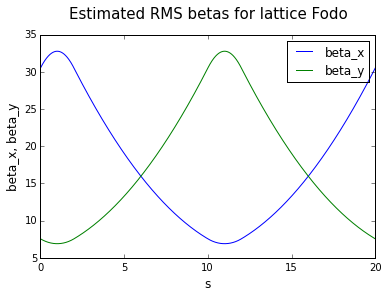

In [13]:
from base_diagnostics import diagplot

testplots = ['x_std','y_std']
numE = opts.steps_per_element*len(lattice.get_elements())
#lname = 'zcG'+lattice.get_name()
lname = 'Fodo'
latlength = lattice.get_length()
fn = 'basic.h5'
turn = 1
save = False
emits = [opts.emitx,opts.emity]
diagplot.diagPlot(fn,testplots,numE,lname,turn-1,save, betas=True, emit=emits, length=latlength)

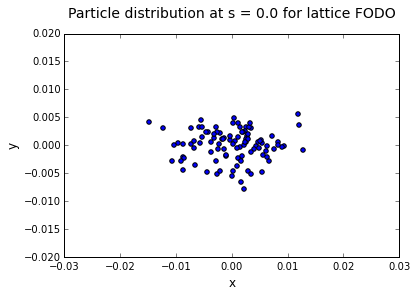

In [16]:
from base_diagnostics import options
from base_diagnostics import plotbeam

popts = options.Options()
#popts.path = 'fodo_output/'
popts.path = ''
popts.inputfile = popts.path + 'particles_0000.h5'
popts.hcoord = 'x'
popts.vcoord = 'y'
popts.lattice_name = 'FODO'
popts.save = False

plotbeam.plot_beam(popts)

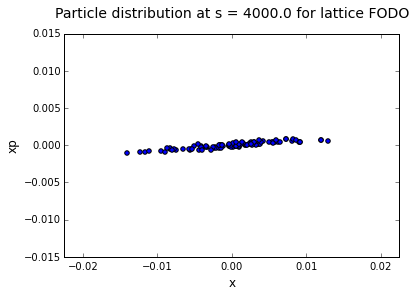

In [17]:
popts = options.Options()
popts.path = ''
popts.inputfile = popts.path+'particles_0200.h5'
popts.hcoord = 'x'
popts.vcoord = 'xp'
popts.lattice_name = 'FODO'
popts.save = False

plotbeam.plot_beam(popts)

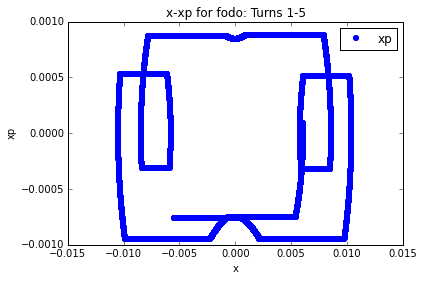

In [24]:
from base_diagnostics import poincare

fn = 'track.h5'
numE = opts.steps_per_element*len(lattice.get_elements())
lname = lattice.get_name()
save=False
start=0
end=5
poincare.poincarePlot(fn,'x','xp',numE,lname,start,end,save)

In [88]:
from base_diagnostics import poincare
numE = opts.steps_per_element*len(lattice.get_elements())
lname = 'Fodo'

#poincare.poincarePlot('turn_track.h5','x','xp',numE,lname)

###Single Particle Invariant - Courant Synder Calculation

The single particle Hamiltonian/Invariant J should be calculated for each particle at the same place every turn. We will calculate the Courant Synder invariant, given by $J = \gamma x^2 + 2 \alpha x x' + \beta x'^2 $, where $\alpha$, $\beta$, and $\gamma$ are the Twiss parameters. The twiss parameters are a function of the lattice, and can be calculated for a given position `s`. Thus it makes sense to either take a per_turn diagnostic (e.g. particles diagnostic) or a tracking diagnostic that is set to dump per turn.

In [22]:
coords = {}
coords['x'] = 0
coords['xp'] = 1
coords['y'] = 2
coords['yp'] = 3
coords['cdt'] = 4
coords['dpop'] = 5
coords['id'] = 6

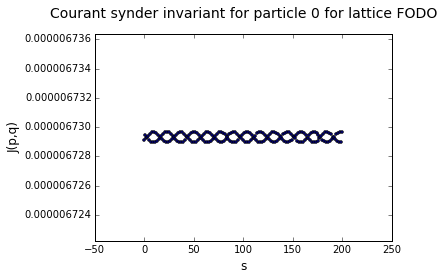

In [100]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.path = 'fodo_output/'
popts.lattice_name = 'FODO'
popts.ID = None
#popts.path = None
popts.turns = 200 
popts.norm = False
popts.coords = coords
popts.lattice_simulator = lattice_simulator
popts.variance = 0.001
popts.relpath = 'fodo_output'

#singleparticle.get_particles

singleparticle.plot_Invariant(popts)

Some of this variation in H may be the result of the nonlinear elements stemming from Synergia's 3rd order mapping in conjunction with the tunes being near some quarter-integer resonances? Some introductory discussion of this is provided by a fairly succinct SLAC report by [Ruth](http://www-spires.slac.stanford.edu/cgi-wrap/getdoc/slac-pub-3836.pdf).

####Adjust tunes and replot single particle Hamiltonian

We can use Synergia's built-in tools to adjust the tunes of our sample fodo lattice and see if positioning ourselves closer to a resonance produces broader variation in the single particle Hamiltonian plot. Recall from a previous ipython notebook, [Synergia Lattice Simulator](http://localhost:8888/notebooks/Synergia%20Lattice%20Simulator.ipynb), that we can adjust the tunes through a straightforward process.

<u>General Approach for Tune Matching</u>:

1. Initial lattice import from file - instantiation of lattice simulator
2. Import options file and specify new tune value
3. Call `adjust_tunes(<args>)`, specifying the following arguments:
    1. A set of new tune values
    2. A set of lattice elements to be adjusted (e.g. quads)
    3. A tolerance for the matching.
4. Update the lattice simulator object using `lattice_simulator.update()`

In [101]:
#define a secondary lattice_simulator for this work

#stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
new_lattice_simulator = stepper.get_lattice_simulator()

x_tune0, y_tune0 = new_lattice_simulator.get_both_tunes()

x_tune1 = 0.25 #place on resonance
y_tune1 = y_tune0
tune_tol = 1.0e-7; #need to define a tolerance for the fit

# get_fd_quads(lattice) reads input lattice and returns
# ( [list of focussing quad elements], [list of defocussing quad elements] )
def get_fd_quads(lattice):
    f_quads = []
    d_quads = []
    for elem in lattice.get_elements():
        if elem.get_type() == "quadrupole":
            k1 = elem.get_double_attribute("k1")
            if k1 > 0.0:
                f_quads.append(elem)
            elif k1 < 0.0:
                d_quads.append(elem)
    return (f_quads, d_quads)

#specify a set of magnets to be adjusted
f_quads, d_quads = get_fd_quads(lattice)

#use these magnets to adjust tune to specified final values
new_lattice_simulator.adjust_tunes(x_tune1,y_tune1,f_quads,d_quads,tune_tol)

#update lattice_simulator and get new lattice
new_lattice_simulator.update()
new_lattice = new_lattice_simulator.get_lattice()

Verify that we have updated the quadrupole strengths in the lattice and met our tune requirements.

In [104]:
#quick helper method
def print_strengths(elemslist):
    for elem in elemslist:
        if elem.get_type() == "quadrupole":
            print elem.get_name() + ' K: ' + str(elem.get_double_attribute("k1"))

#Force define original lattice simulator
lattice = synergia.lattice.Mad8_reader().get_lattice("fodo","fodo.lat")
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()
print str(lattice_simulator.get_horizontal_tune()) + " is the original x-tune"

f_quads, d_quads = get_fd_quads(lattice)

print_strengths(f_quads)
print_strengths(d_quads)

print str(new_lattice_simulator.get_horizontal_tune()) + " is the new x-tune"

new_f_quads, new_d_quads = get_fd_quads(new_lattice)

print_strengths(new_f_quads)
print_strengths(new_d_quads)

0.231443966746 is the original x-tune
f K: 0.0714285714286
d K: -0.0714285714286
0.249999993841 is the new x-tune
f K: 0.0752632756072
d K: -0.0722634829434


Now we can re-run the simulation and compare the the particle behavior. Remember to construct a new stepper and a new matched bunch.

In [133]:
#Construct new stepper
new_stepper = synergia.simulation.Independent_stepper_elements(new_lattice, opts.map_order, opts.steps_per_element)

#Construct a bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    new_lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5")
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5")
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("track.h5", 1))

#Diagnostics per turn - useful for invariant tracking
#bulktrackdiag = synergia.bunch.Diagnostics_bulk_track("turn_track.h5", opts.tracked_particles, 0)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_bulk_track("turn_track.h5", 2))

#bunch_simulator.add_per_turn(bulktrackdiag)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5")
bunch_simulator.add_per_turn(particlediag)

#~0.2s per turn for run with 100 macroparticles, ds = 0.01, 3rd order map
propagator = synergia.simulation.Propagator(new_stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.max_turns, 
                     opts.verbosity)

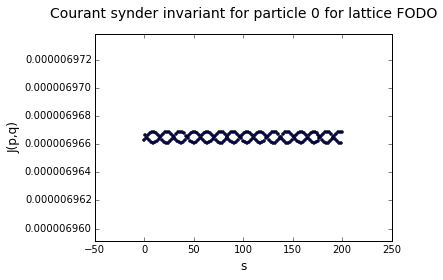

In [107]:
popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.lattice_name = 'FODO'
popts.ID = None
popts.path = None
popts.turns = 200 
popts.norm = False
popts.save = True
popts.lattice_simulator = new_lattice_simulator
popts.variance = 0.001
popts.relpath = 'fodo_quarter_xtune'

from base_diagnostics import options
from base_diagnostics import singleparticle

singleparticle.plot_Invariant(popts)

####Perform the same simulation but with a 1st order map
One can also investigate the variations introducted by the 3rd order mapping constructed by Synergia. I'll create a 1st order lattice and re-run.

In [8]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("symfodo","fodo.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #note this isn't using future division, so returns int

import synergia_workflow

opts = synergia_workflow.Options("fodo")
opts.add("map_order", 1, "map order")
opts.add("steps_per_element", nsteps_per_element, "steps per element")
opts.add("emitx", 1.0e-6, "x RMS emittance [m-rad]")
opts.add("emity", 1.0e-6, "y RMS emittance [m-rad]")
opts.add("stdz", 0.01, "z RMS length [m]")
opts.add("dpop", 1.0e-4, "(delta p)/p")
opts.add("real_particles", 1.2e12, "number of physical particles in bunch")
opts.add("macro_particles", 100, "number of simulation particles")
opts.add("tracked_particles", opts.macro_particles, "number of tracked particles")
opts.add("seed", 1415926, "random number seed; 0 for automatic calculation (GSL)")
opts.add("turns", 200, "number of times to track through fodo lattice")
opts.add("max_turns", 201, "maximum number of turns to run before checkpointing and stopping; 0 to not stop")
opts.add("checkpointperiod", 2000, "Number of turns to run between checkpoints", int)
opts.add("verbosity", 1, "verbosity level of simulation")

In [7]:
#Construct new stepper
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#Construct a bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5")
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5")
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("track.h5", 1))

#Diagnostics per turn - useful for invariant tracking
#bulktrackdiag = synergia.bunch.Diagnostics_bulk_track("turn_track.h5", opts.tracked_particles, 0)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_bulk_track("turn_track.h5", 2))

#bunch_simulator.add_per_turn(bulktrackdiag)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5")
bunch_simulator.add_per_turn(particlediag)

#~0.2s per turn for run with 100 macroparticles, ds = 0.01, 3rd order map
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.max_turns, 
                     opts.verbosity)

KeyboardInterrupt: 

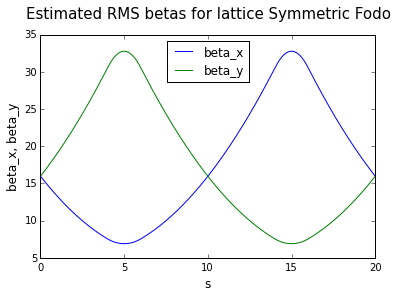

In [9]:
from base_diagnostics import diagplot

testplots = ['x_std','y_std']
numE = opts.steps_per_element*len(lattice.get_elements())
#lname = 'zcG'+lattice.get_name()
lname = 'Symmetric Fodo'
latlength = lattice.get_length()
#fn = 'fodo_symmetric/basic.h5'
fn = 'basic.h5'
turn = 1
save = True
emits = [opts.emitx,opts.emity]
diagplot.diagPlot(fn,testplots,numE,lname,turn-1,save, betas=True, emit=emits, length=latlength)

In [10]:
for elem in lattice.get_elements():
    print elem.as_string()

symfodo: drift oh: l=4
symfodo: quadrupole d: k1=-0.0714286, l=2
symfodo: drift o: l=8
symfodo: quadrupole f: k1=0.0714286, l=2
symfodo: drift oh: l=4


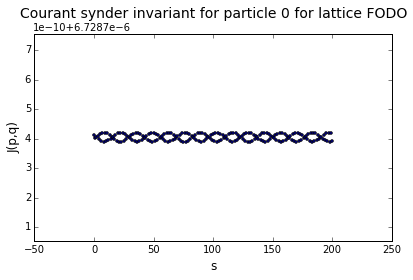

In [16]:
from base_diagnostics import options
from base_diagnostics import singleparticle

#Construct new stepper
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.lattice_name = 'FODO'
popts.ID = None
popts.path = None
popts.turns = 200 
popts.norm = False
popts.save = True
popts.lattice_simulator = lattice_simulator
popts.variance = 0.00005
popts.relpath = 'fodo_symmetric'

singleparticle.plot_Invariant(popts)

For the 1st order (symplectic) map, the variation in the invariant is greater than a factor of 10 lower, even for the same fodo lattice!

####Try a different lattice - foborodobo.lat 

After exploring the diagnostics with simple variations on a fodo lattice, let's consider a larger ring. This is still a linear ring, distributed by Jim Admuson at the USPAS 2015 Computational Accelerator Physics one-week course, and obtainable at the [fnal course wiki](https://cdcvs.fnal.gov/redmine/projects/uspas15/wiki).

**Note: This is a larger lattice and a longer run - it will likely take ~10-15 minutes to complete 200 turns on a single core**

In [16]:
#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model","foborodobo32.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #note this isn't using future division, so returns int

import synergia_workflow

opts = synergia_workflow.Options("foborodobo32")
opts.add("map_order", 1, "map order")
opts.add("steps_per_element", nsteps_per_element, "steps per element")
opts.add("emitx", 1.0e-6, "x RMS emittance [m-rad]")
opts.add("emity", 1.0e-6, "y RMS emittance [m-rad]")
opts.add("stdz", 0.01, "z RMS length [m]")
opts.add("dpop", 1.0e-4, "(delta p)/p")
opts.add("real_particles", 1.2e12, "number of physical particles in bunch")
opts.add("macro_particles", 100, "number of simulation particles")
opts.add("tracked_particles", opts.macro_particles, "number of tracked particles")
opts.add("seed", 1415926, "random number seed; 0 for automatic calculation (GSL)")
opts.add("turns", 1000, "number of times to track through fodo lattice")
opts.add("max_turns", 200, "maximum number of turns to run before checkpointing and stopping; 0 to not stop")
opts.add("checkpointperiod", 2000, "Number of turns to run between checkpoints", int)
opts.add("verbosity", 1, "verbosity level of simulation")

#Construct new stepper
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()

#Construct a bunch
myBunch = synergia.optics.generate_matched_bunch_transverse(
    lattice_simulator, opts.emitx, opts.emity, opts.stdz, 
    opts.dpop, opts.real_particles, 
    opts.macro_particles, opts.seed) 

# Define a bunch simulator
bunch_simulator = synergia.simulation.Bunch_simulator(myBunch)

# Define a set of bunch diagnostics

#basic diagnostics - PER STEP
basicdiag = synergia.bunch.Diagnostics_basic("basic.h5")
bunch_simulator.add_per_step(basicdiag)

#include full diagnostics
fulldiag = synergia.bunch.Diagnostics_full2("full.h5")
bunch_simulator.add_per_turn(fulldiag)

#tracking diagnostics - PER STEP
bunch_simulator.add_per_step(synergia.bunch.Diagnostics_track("track.h5", 1))

#Diagnostics per turn - useful for invariant tracking
#bulktrackdiag = synergia.bunch.Diagnostics_bulk_track("turn_track.h5", opts.tracked_particles, 0)
#Track a particle twice per turn (e.g. every ~ num_steps/2 add the diagnostic)
bunch_simulator.add_per_turn(synergia.bunch.Diagnostics_bulk_track("turn_track.h5", 2))

#bunch_simulator.add_per_turn(bulktrackdiag)

#particle diagnostics - PER TURN
particlediag = synergia.bunch.Diagnostics_particles("particles.h5")
bunch_simulator.add_per_turn(particlediag)

#~4-5s per turn for foborodbo run with 100 macroparticles, ds = 0.01, 1st order map
#basic diagnostics file  - 2.26 GB
propagator = synergia.simulation.Propagator(stepper)
propagator.set_checkpoint_period(opts.checkpointperiod)
propagator.propagate(bunch_simulator, opts.turns, opts.max_turns, 
                     opts.verbosity)

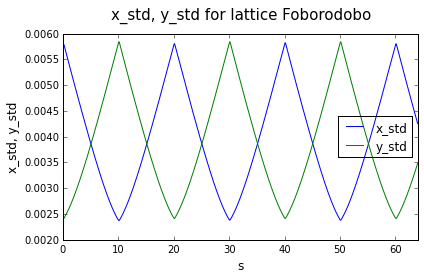

In [19]:
from base_diagnostics import diagplot

testplots = ['x_std','y_std']
numE = opts.steps_per_element*len(lattice.get_elements())
#lname = 'zcG'+lattice.get_name()
lname = 'Foborodobo'
latlength = lattice.get_length()
fn = 'foborodobo_output/basic.h5'
turn = 1
save = True
emits = [opts.emitx,opts.emity]
diagplot.diagPlot(fn,testplots,numE,lname,turn-1,save, betas=False, emit=emits, length=latlength/10)

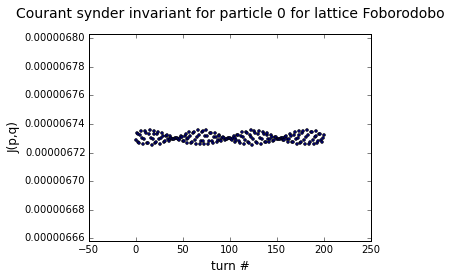

In [22]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.lattice_name = 'Foborodobo'
popts.ID = None
popts.path = None
popts.turns = 200 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.relpath = 'foborodobo_output'

singleparticle.plot_Invariant(popts)

##Single Particle Tracks

This can either use the same basic `particles` extraction or the per-turn tracking. The first diagnostic I wrote builds off of the `singleparticle.py` module in `base_diagnostics`, which reads in particles files and plots coordinate spaces.

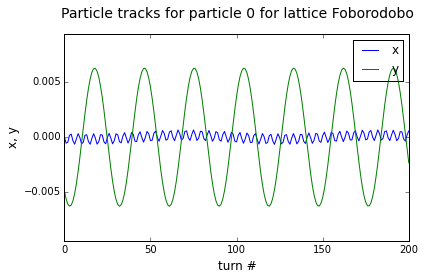

In [24]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
#opts.inputfile = 'particles_0000.h5'
#opts.hcoord = 'x'
#opts.vcoord = 'xp'
popts.lattice_name = 'Foborodobo'
popts.ID = None
popts.path = None
popts.turns = 200 
popts.norm = False
popts.save = True
#popts.lattice_simulator = lattice_simulator
popts.relpath = 'foborodobo_output'
popts.plots = ['x','y']

singleparticle.track(popts)

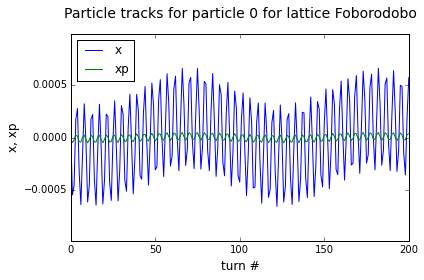

In [25]:
popts.plots = ['x','xp']
popts.save = False
singleparticle.track(popts)

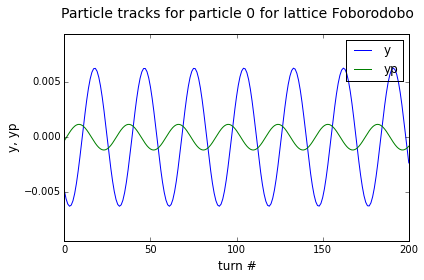

In [26]:
popts.plots = ['y','yp']
popts.save = False
singleparticle.track(popts)

##Poincare Plots Revisited

Let's improve the poincare plot to produce the trajectory in normalized coordinates, such that for linear dynamics the particle traverses a circle in phase space. We will still consider the output from the fodo lattice run, with the goal of producing some basic circular trajectories.

In [16]:
from base_diagnostics import options
from base_diagnostics import singleparticle


popts = options.Options()
popts.lattice_name = 'FODO'
popts.ID = None
popts.path = None
popts.turns = 200 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = lattice_simulator
popts.plots = ['x','px']

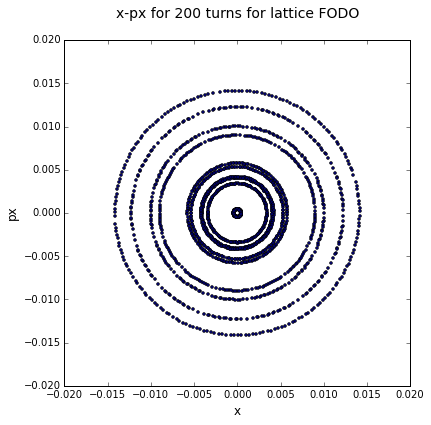

In [17]:
singleparticle.plot_Poincare(popts)